Inladen data, converteren naar gpkg (dan kun je met sqlite werken en lagen toevoegen)
shp gehaald van https://maps.rijkswaterstaat.nl/dataregister/srv/dut/catalog.search#/metadata/db60a314-5583-437d-a2ff-1e59cc57704f

In [4]:
import os
import logging
from osgeo import ogr, gdal
import pyarrow as pa
import time
import numpy as np
import geopandas as gp
import pandas as pd
import geopandas as gpd
from geopandas.array import from_wkb
from osgeo import ogr
from shapely.geometry import LineString
import math
import folium
import networkx as nx
ogr.UseExceptions()
pd.set_option('display.max_columns', None)

#alvast een logger klaarzetten
class Logger:
    def __init__(self, log_dir="log"):
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
        log_file = os.path.join(log_dir, "conversion.log")
        logging.basicConfig(
            level=logging.INFO,
            format="%(asctime)s - %(levelname)s - %(message)s",
            handlers=[
                logging.FileHandler(log_file),
                logging.StreamHandler()
            ]
        )
        self.logger = logging.getLogger()

    def info(self, message):
        self.logger.info(message)

    def error(self, message):
        self.logger.error(message)

##OVERBODIG!! rijkswaterstaat geeft gewoon gpkg 😔
class ShapefileConverter:
    def __init__(self, logger):
        self.logger = logger

    def convert_shapefiles_to_geopackage(self, input_shapefiles, output_geopackage):
        try:
            if not input_shapefiles:
                raise ValueError("No input shapefiles provided.")

            for input_shapefile in input_shapefiles:
                if not os.path.exists(input_shapefile):
                    self.logger.error(f"Input shapefile not found: {input_shapefile}")
                    raise FileNotFoundError(f"Shapefile not found: {input_shapefile}")

                self.logger.info(f"Processing shapefile: {input_shapefile}")

                try:
                    srcDS = gdal.OpenEx(input_shapefile, allowed_drivers=['ESRI Shapefile'])
                    if srcDS is None:
                        raise RuntimeError(f"Failed to open shapefile: {input_shapefile}")

                    options = gdal.VectorTranslateOptions(
                        format='GPKG', accessMode='append', srcSRS='EPSG:25831', dstSRS='EPSG:28992',
                        addFields=True
                    )

                    gdal.VectorTranslate(srcDS=srcDS, destNameOrDestDS=output_geopackage, options=options)
                    self.logger.info(f"Successfully converted: {input_shapefile} to {output_geopackage}")

                    srcDS.Close()

                except Exception as e:
                    self.logger.error(f"Error processing shapefile {input_shapefile}: {e}")
                    raise

        except Exception as e:
            self.logger.error(f"Unexpected error during conversion: {e}")
            raise

        self.logger.info("All shapefiles processed.")
        return 'success'

if __name__ == "__main__":
    #files
    input_shapefiles = [
        r"..\data\vaarweg_markering_drijvend_detail\vaarweg_markering_drijvend_detailPoint.shp",
        r"..\data\vaarweg_markering_vast_detail\vaarweg_markering_vast_detailPoint.shp"
    ]
    output_geopackage = r"..\data\converted_datav2.gpkg"

    #init logger & converter
    logger = Logger()
    converter = ShapefileConverter(logger)

    #run
    converter.convert_shapefiles_to_geopackage(input_shapefiles, output_geopackage) #letop, 2x runnen geeft dubbele resultaten ivm accessMode = append


2024-12-12 18:15:11,223 - INFO - Processing shapefile: ..\data\vaarweg_markering_drijvend_detail\vaarweg_markering_drijvend_detailPoint.shp


2024-12-12 18:15:11,580 - INFO - Successfully converted: ..\data\vaarweg_markering_drijvend_detail\vaarweg_markering_drijvend_detailPoint.shp to ..\data\converted_datav2.gpkg
2024-12-12 18:15:11,585 - INFO - Processing shapefile: ..\data\vaarweg_markering_vast_detail\vaarweg_markering_vast_detailPoint.shp
2024-12-12 18:15:12,091 - INFO - Successfully converted: ..\data\vaarweg_markering_vast_detail\vaarweg_markering_vast_detailPoint.shp to ..\data\converted_datav2.gpkg
2024-12-12 18:15:12,093 - INFO - All shapefiles processed.


In [5]:
def load(gpkg_path, layername):
    """
    Loads a specified layer from a GeoPackage and returns it as a GeoDataFrame.

    Parameters:
    - gpkg_path (str): Path to the GeoPackage file.
    - layername (str): Name of the layer to load.

    Returns:
    - gdf (GeoDataFrame): The loaded layer as a GeoDataFrame.
    """
    t1 = time.time()
    gdf = None
    df = None
    datasource = None
    try:
        #Connect to gpkg
        driver = ogr.GetDriverByName('GPKG')
        datasource = driver.Open(gpkg_path, 0)  # 0 = read-only
        if datasource is None:
            raise ValueError(f"Failed to open GeoPackage: {gpkg_path}")

        #access the specified layer/table
        layer = datasource.GetLayerByName(layername)
        if layer is None:
            raise ValueError(f"Layer '{layername}' not found in {gpkg_path}")
        logger.info(f"Loaded layer '{layername}' from {gpkg_path}")

        #Arrow streams
        arrow_stream = layer.GetArrowStreamAsPyArrow()
        if arrow_stream is None:
            raise RuntimeError("Failed to retrieve Arrow stream from the layer.")
        logger.info("Loaded OGR Arrow stream")

        schema = arrow_stream.schema  # Retrieve schema
        logger.info(f"Schema retrieved: {schema}")

        #field names from the schema
        fields = [field for field in schema]
        field_names = [field.name for field in fields if field.name]  # Ensure field has a name
        logger.info(f"Field names extracted: {field_names}")

        #schema_object using field names
        schema_object = pa.schema([schema.field(i) for i in range(schema.num_fields)])
        logger.info(f"Schema object defined: {schema_object}")

        #create table from batches
        batches = []
        for record_batch in arrow_stream:
            # Access fields by name
            arrays = [record_batch.field(field_name) for field_name in field_names]
            batch = pa.RecordBatch.from_arrays(arrays, schema=schema_object)
            batches.append(batch)

        #combine batches into a single table
        table = pa.Table.from_batches(batches).combine_chunks()
        logger.info(f"Created PyArrow table with {table.num_rows} rows and {table.num_columns} columns.")

        #convert table to pandas DataFrame and gdf
        df = table.to_pandas()
        logger.info("Converted PyArrow table to pandas DataFrame")
        geometry_column = None
        for col in df.columns:
            if 'geom' in col.lower() or 'geometry' in col.lower():
                geometry_column = col
                break
            
        # Convert WKB to geometry using GeoPandas
        geometry = from_wkb(df[geometry_column])
        gdf = gp.GeoDataFrame(df, geometry=geometry, crs = "EPSG:28992")
        gdf = gdf.drop(columns=["geom"]) 
        logger.info("Converted DataFrame to GeoDataFrame")

        t2 = time.time()
        logger.info(f"Data loaded successfully in {t2 - t1:.2f} seconds.")

        return gdf

    except Exception as e:
        logger.error(f"An error occurred while loading the layer '{layername}': {e}")
        raise

    finally:
        if datasource:
            datasource.Close()
            logger.info(f"Closed the GeoPackage datasource: {gpkg_path}")

if __name__ == "__main__":

    gpkg_path = r'..\data\converted_datav2.gpkg'  
    layer_name = 'vaarweg_markering_drijvend_detailPoint'  

    gdf = load(gpkg_path, layer_name)
    #print(gdf.head())  
gdf


2024-12-12 18:15:12,188 - INFO - Loaded layer 'vaarweg_markering_drijvend_detailPoint' from ..\data\converted_datav2.gpkg
2024-12-12 18:15:12,196 - INFO - Loaded OGR Arrow stream
2024-12-12 18:15:12,200 - INFO - Schema retrieved: struct<fid: int64 not null, vaarwater: string, benam_cod: string, benaming: string, inbedrijf: string, x_rd: string, y_rd: string, obj_soort: string, iala_categ: string, n_wgs_gms: string, e_wgs_gms: string, n_wgs_gm: string, e_wgs_gm: string, obj_vorm_c: string, obj_vorm: string, obj_kleur_: string, obj_kleur: string, kleurpatr_: string, kleurpatr: string, v_tt_c: string, tt_toptek: string, tt_kleur_c: string, tt_kleur: string, tt_pat_c: string, tt_klr_pat: string, sign_kar_c: string, sign_kar: string, sign_gr_c: string, sign_groep: string, sign_perio: string, racon_code: string, licht_kl_c: string, licht_klr: string, opgeheven: string, x_wgs84: double, y_wgs84: double, vorm_kleur: string, s57_id: int32, geom: binary>
2024-12-12 18:15:12,200 - INFO - Field na

,fid,vaarwater,benam_cod,benaming,inbedrijf,x_rd,y_rd,obj_soort,iala_categ,n_wgs_gms,e_wgs_gms,n_wgs_gm,e_wgs_gm,obj_vorm_c,obj_vorm,obj_kleur_,obj_kleur,kleurpatr_,kleurpatr,v_tt_c,tt_toptek,tt_kleur_c,tt_kleur,tt_pat_c,tt_klr_pat,sign_kar_c,sign_kar,sign_gr_c,sign_groep,sign_perio,racon_code,licht_kl_c,licht_klr,opgeheven,x_wgs84,y_wgs84,vorm_kleur,s57_id,geometry
0,1,AARDAPPELENGAT,VW-A -0101,A 21,01-01-2005,"72384,1773","421540,5036",SK31 630,4,51.46.35.11,004.11.24.30,51.46.5852,004.11.4050,5,spar,4,Groen,#,Niet toegewezen,1,"Kegel, punt naar boven",4,Groen,#,Niet toegewezen,#,Niet toegewezen,#,Niet toegewezen,#,#,#,Niet toegewezen,#,4.190083,51.776419,spar Groen,1044,POINT (72384.362 421540.675)
1,2,AARDAPPELENGAT,VW-A -0102,A 19,01-01-2005,"71915,3833","421600,9262",SK31 630,4,51.46.36.81,004.10.59.79,51.46.6135,004.10.9965,5,spar,4,Groen,#,Niet toegewezen,#,Niet toegewezen,#,Niet toegewezen,#,Niet toegewezen,#,Niet toegewezen,#,Niet toegewezen,#,#,#,Niet toegewezen,#,4.183275,51.776892,spar Groen,1042,POINT (71915.403 421600.961)
2,3,AARDAPPELENGAT,VW-A -0103,A 17,01-01-2005,"71305,1921","421800,7938",SK31 630,4,51.46.42.95,004.10.27.79,51.46.7158,004.10.4632,5,spar,4,Groen,#,Niet toegewezen,#,Niet toegewezen,#,Niet toegewezen,#,Niet toegewezen,#,Niet toegewezen,#,Niet toegewezen,#,#,#,Niet toegewezen,#,4.174386,51.778597,spar Groen,1042,POINT (71305.172 421800.882)
3,4,AARDAPPELENGAT,VW-A -0104,A 18,01-01-2005,"71394,1015","421958,7968",SK32 630,4,51.46.48.11,004.10.32.29,51.46.8018,004.10.5382,5,spar,3,Rood,#,Niet toegewezen,#,Niet toegewezen,#,Niet toegewezen,#,Niet toegewezen,#,Niet toegewezen,#,Niet toegewezen,#,#,#,Niet toegewezen,#,4.175636,51.780031,spar Rood,1142,POINT (71394.083 421958.894)
4,5,AARDAPPELENGAT,VW-A -0105,A 15,01-01-2005,"70730,0620","421975,8322",SK31 630,4,51.46.48.30,004.09.57.64,51.46.8050,004.09.9607,5,spar,4,Groen,#,Niet toegewezen,#,Niet toegewezen,#,Niet toegewezen,#,Niet toegewezen,#,Niet toegewezen,#,Niet toegewezen,#,#,#,Niet toegewezen,#,4.166011,51.780083,spar Groen,1042,POINT (70730.037 421975.871)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19817,19818,ZWOLSCHEDIEP (RANDMEREN),VW-ZDR -0132,LZD-N,01-01-2005,"198103,9045","516715,7031",SK31 630,3,52.38.10.46,006.01.26.21,52.38.1743,006.01.4369,5,spar,6,Geel,#,Niet toegewezen,5,Cilinder,"3,1,3",Rood/wit/rood,1,Horizontaal,#,Niet toegewezen,#,Niet toegewezen,#,#,#,Niet toegewezen,#,6.023947,52.636239,spar Geel,5541,POINT (198104.013 516716)
19818,19819,ZWOLSCHEDIEP (RANDMEREN),VW-ZDR -0133,LZD-O,01-01-2005,"198161,8658","516706,7554",SK31 630,3,52.38.10.15,006.01.29.29,52.38.1692,006.01.4882,5,spar,6,Geel,#,Niet toegewezen,5,Cilinder,"3,1,3",Rood/wit/rood,1,Horizontaal,#,Niet toegewezen,#,Niet toegewezen,#,#,#,Niet toegewezen,#,6.024803,52.636153,spar Geel,5541,POINT (198162.013 516706.929)
19819,19820,ZWOLSCHEDIEP (RANDMEREN),VW-ZDR -0134,LZD-P,01-01-2005,"198219,9401","516697,8093",SK31 630,3,52.38.09.85,006.01.32.38,52.38.1641,006.01.5396,5,spar,6,Geel,#,Niet toegewezen,5,Cilinder,"3,1,3",Rood/wit/rood,1,Horizontaal,#,Niet toegewezen,#,Niet toegewezen,#,#,#,Niet toegewezen,#,6.025661,52.636069,spar Geel,5541,POINT (198220.199 516698.169)
19820,19821,ZWOLSCHEDIEP (RANDMEREN),VW-ZDR -0135,LZD-Q,01-01-2005,"198265,9245","516690,7971",SK31 630,3,52.38.09.61,006.01.34.82,52.38.1601,006.01.5803,5,spar,6,Geel,#,Niet toegewezen,5,Cilinder,"3,1,3",Rood/wit/rood,1,Horizontaal,#,Niet toegewezen,#,Niet toegewezen,#,#,#,Niet toegewezen,#,6.026339,52.636003,spar Geel,5541,POINT (198266.146 516691.157)


In [6]:
#foutgevoelig, met het oog uit pdf gehaald en bekeken in Qgis
#aanwezigheid en locatie boei is in Qgis gecheckt.
#vaarwater : [boeien] relaties, vaarwater benodigd omdat sommige boeiennamen dubbel voorkwamen (bijvoorbeeld K 2 in ijselmeer)
vaarwater_boeien = {"KRAMMER": ["K 2"],
               "KEETEN-MASTGAT-ZIJPE" : ["KT 42-ZG 1", 
                                         "KEETEN A",
                                         "KEETEN B",
                                         "KT 1-EV 2",
                                         "KT 2",
                                         "KT 10",
                                         "KT 13",
                                         "KT 14",
                                         "KT 18", 
                                         "KT 21", 
                                         "KT 24", 
                                         "KT 28", 
                                         "KT 31", 
                                         "KT 27-KR 2"],
               "ENGELSCHE VAARWATER": ["EV 6",
                                       "EV 7-O 4",
                                       "EV 10"
                                       ],
               "OOSTERSCHELDE": ["O 1",
                                 "O 11-Z 2",
                                 "O 15-SAS 2",
                                 "O 18",
                                 "O 22",
                                 "O 25-SVY 2",
                                 "O 28-D 15",
                                 "O 33"],
               "ZANDKREEK": ["Z 1"],       #start 4, niet onderdeel?
               "THOLENSCHE GAT":["TG 4",  #start 3
                                  "TG 3"], #start 3
               "PIETERMANSKREEK": ["PK 4",
                                   "PK 8"],
               "LODIJKSCHE GAT": ["LG 5-PK 2",
                                  "LG 8",
                                  "LG 14"],
               "KRABBENKREEK":["KR 1", "KR 7", "KR 8", "KR 15"]}

rakken = {2:("K 2", "KT 27-KR 2"),
          3:("K 2", "KT 28"),
          4:("K 2", "KT 42-ZG 1"),
          5:("KT 42-ZG 1", "KT 27-KR 2"),
          6:("KT 42-ZG 1", "KT 28"),
          7:("KT 28", "KT 27-KR 2"),
          8:("KT 31", "KT 27-KR 2"),
          9:("KT 31", "KT 28"),
          10:("KR 1", "KT 27-KR 2"),
          11:("KT 21", "KT 27-KR 2"),
          12:("KT 24", "KT 27-KR 2"),
          13:("KT 28", "KT 21"),
          14:("KT 28", "KT 24"),
          15:("KT 21", "KR 1"),
          16:("KT 21", "KT 24"),
          17:("KT 24", "KT 18"),
          18:("KT 21", "KT 13"),
          19:("KT 14", "KT 18"),
          20:("KT 13", "KEETEN B"),
          21:("KT 10", "KT 14"),
          22:("KT 10", "KEETEN B"),
          23:("KT 10", "KEETEN A"),
          24:("KEETEN B", "KT 1-EV 2"),
          25:("KT 1-EV 2", "KEETEN A"),
          26:("KT 1-EV 2", "EV 6"),
          27:("KEETEN A", "EV 6"),
          28:("KEETEN A", "EV 7-O 4"),
          29:("KEETEN A", "O 1"),
          30:("EV 6", "EV 7-O 4"),
          31:("O 1", "EV 7-O 4"),
          32:("EV 6", "EV 10"),
          33:("O 11-Z 2", "EV 10"),
          34:("O 11-Z 2", "O 1"),
          35:("O 11-Z 2", "EV 7-O 4"),
          36:("O 11-Z 2", "O 18"),
          37:("O 11-Z 2", "O 15-SAS 2"),
          38:("O 18", "O 15-SAS 2"),
          39:("O 15-SAS 2", "O 22"),
          40:("O 18", "O 22"),
          41:("O 22", "O 25-SVY 2"),
          42:("O 22", "O 28-D 15"),
          43:("O 28-D 15", "O 25-SVY 2"),
          44:("O 33", "O 25-SVY 2"),
          45:("O 33", "O 28-D 15"),
          46:("O 33", "LG 8"),
          47:("O 33", "LG 5-PK 2"),
          48:("LG 5-PK 2", "PK 4"),
          49:("PK 4", "PK 8"),
          50:("LG 5-PK 2", "LG 8"),
          51:("LG 8", "LG 14"),
            }

#aantal boeien in dict
lenb = 0
for i in vaarwater_boeien:
    lenb += len(vaarwater_boeien[i]) 
print(lenb)#38 features

#boeien selecteren uit gdf
gdf_8uren = gdf[gdf.apply(lambda row: row["benaming"] in vaarwater_boeien.get(row["vaarwater"], []), axis=1)]

#aantal boeien gdf
print(len(gdf_8uren)) #38 features

#checks
if not len(gdf_8uren) == lenb:
    print("oeps, wss typefout in dict")
if not len(gdf_8uren) == 38:
    print("oeps, niet aantal als in kaart.pdf")


38
76
oeps, wss typefout in dict
oeps, niet aantal als in kaart.pdf


In [7]:
from shapely.geometry import LineString
import geopandas as gpd
import math

#functie om de richting (bearing) te berekenen
def calculate_bearing(start_point, end_point):
    """
    Bereken de richting (bearing) in graden t.o.v. noorden.
    """
    delta_x = end_point.x - start_point.x
    delta_y = end_point.y - start_point.y
    angle = math.atan2(delta_x, delta_y) 
    bearing = math.degrees(angle)
    return (bearing + 360) % 360 

#maak een lijst voor rak lijn geometrien
lines = []

for rak_nr, (start, end) in rakken.items():
    #geometrieën van beide boeien
    start_boei = gdf_8uren[gdf_8uren["benaming"] == start].geometry.values[0]
    eind_boei = gdf_8uren[gdf_8uren["benaming"] == end].geometry.values[0]
    
    #(LineString) tussen de twee boeien
    line = LineString([start_boei, eind_boei])
    
    #bearing voor beide beide richtingen
    bearing_start_to_end = calculate_bearing(start_boei, eind_boei)
    bearing_end_to_start = calculate_bearing(eind_boei, start_boei)
    
    #rakgegevens
    lines.append({
        "rak_nr": rak_nr,
        "start_boei": start,
        "eind_boei": end,
        "bearing_start_to_end": bearing_start_to_end,
        "bearing_end_to_start": bearing_end_to_start,
        "geometry": line
    })

#GeoDataFrame maken
rakken_gdf = gpd.GeoDataFrame(lines, crs=gdf_8uren.crs)

#check
print(rakken_gdf[["rak_nr", "start_boei", "eind_boei", "bearing_start_to_end", "bearing_end_to_start"]].head())


   rak_nr  start_boei   eind_boei  bearing_start_to_end  bearing_end_to_start
0       2         K 2  KT 27-KR 2            222.493229             42.493229
1       3         K 2       KT 28            228.089943             48.089943
2       4         K 2  KT 42-ZG 1            257.859861             77.859861
3       5  KT 42-ZG 1  KT 27-KR 2            209.144238             29.144238
4       6  KT 42-ZG 1       KT 28            218.306044             38.306044


In [8]:
#reproject naar WGS84 (EPSG:4326) ivm folium
gdf_8uren_wgs84 = gdf_8uren.to_crs(epsg=4326)
rakken_gdf_wgs84 = rakken_gdf.to_crs(epsg=4326)

#init folium map
m = folium.Map(location=[
    gdf_8uren_wgs84.geometry.y.mean(),
    gdf_8uren_wgs84.geometry.x.mean()
], zoom_start=12)

#voeg rakken toe
for _, rak in rakken_gdf_wgs84.iterrows():
    #polyline voor rakken
    folium.PolyLine(
        locations=[(point[1], point[0]) for point in rak.geometry.coords], 
        color="blue",
        weight=2,
        opacity=0.8
    ).add_to(m)

    #label met het rak nummer en een witte cirkel
    midpoint = rak.geometry.interpolate(0.5, normalized=True)  
    folium.Marker(
        location=[midpoint.y, midpoint.x],
        icon=folium.DivIcon(
            html=f'''
                <div style="
                    font-size: 8px; 
                    font-weight: bold; 
                    color: black; 
                    background-color: white; 
                    border-radius: 50%; 
                    padding: 3px; 
                    border: 1px solid black; 
                    text-align: center; 
                    width: 15px; 
                    height: 15px; 
                    display: flex; 
                    justify-content: center; 
                    align-items: center;">
                    {rak["rak_nr"]}
                </div>
            '''
        )
    ).add_to(m)

#voeg de boeien toe als cirkels en labels
for _, boei in gdf_8uren_wgs84.iterrows():
    #cirkel voor de boei
    folium.CircleMarker(
        location=[boei.geometry.y, boei.geometry.x],
        radius=3,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.8
    ).add_to(m)

    #tekstlocatie (offset)
    text_location = [boei.geometry.y + 0.001, boei.geometry.x]

    #voeg een streepje toe tussen de boei en de tekstlocatie
    folium.PolyLine(
        locations=[(boei.geometry.y, boei.geometry.x), text_location],  # Van boei naar tekst
        color="black",
        weight=1,
        opacity=0.5
    ).add_to(m)

    #label met de naam van de boei
    folium.Marker(
        location=text_location,  
        icon=folium.DivIcon(
            html=f'<div style="font-size: 10px; font-weight: bold; color: black; text-align: left; white-space: nowrap;">{boei["benaming"]}</div>'
        )
    ).add_to(m)

#show
m


Network 

In [9]:
#Init graphg
G = nx.Graph()

#boeien als nodes toevoegen, voorlopig simpel
for _, boei in gdf_8uren.iterrows():
    G.add_node(boei["benaming"], pos=(boei.geometry.x, boei.geometry.y))

#rakken toevoegen als egdes
for _, rak in rakken_gdf.iterrows():
    #als makkelijke test: raklengte als gewicht
    rak_lengte = rak.geometry.length 
    G.add_edge(rak["start_boei"], rak["eind_boei"], weight=rak_lengte, rak_nr = rak["rak_nr"])


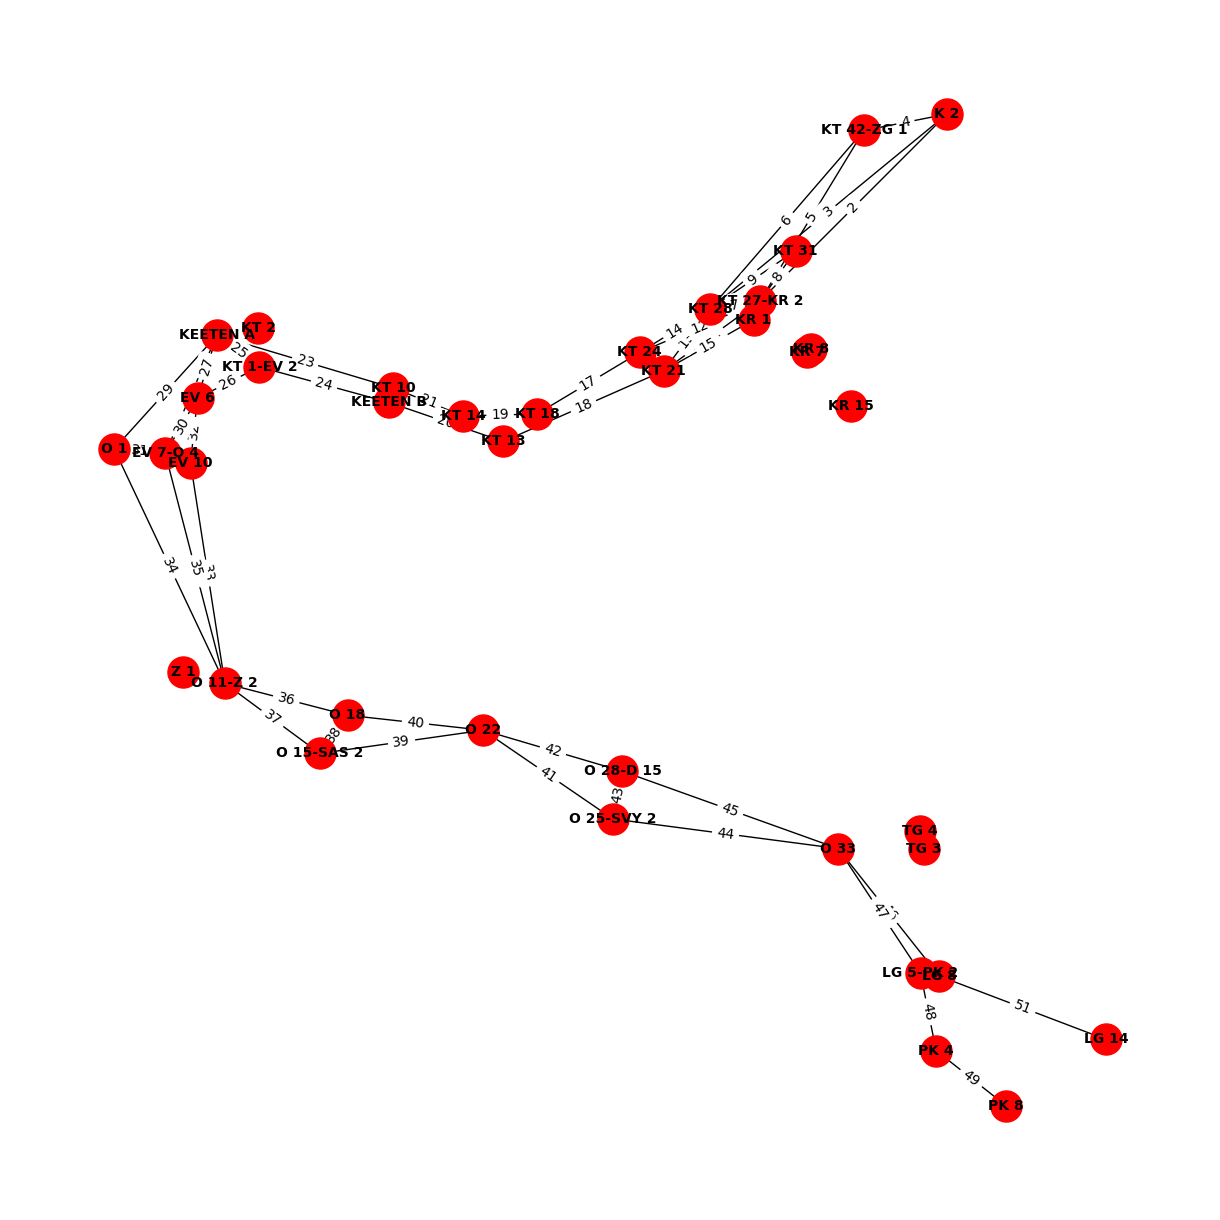

In [10]:
#network plotten
import matplotlib.pyplot as plt

#posities van de nodes en edges
nodes = nx.get_node_attributes(G, 'pos')              #boeien
edge_rak_nummer = nx.get_edge_attributes(G, 'rak_nr') #rakken

#teken het netwerk
plt.figure(figsize=(12, 12))
nx.draw(G, nodes, with_labels=True, node_size=500, node_color="red", font_size=10, font_weight="bold") 
nx.draw_networkx_edge_labels(G, nodes, edge_labels=edge_rak_nummer)
plt.show()


In [11]:
#snelle check
start_node = "K 2"  #start boei
end_node = "PK 8"   #doel boei

if start_node in G.nodes and end_node in G.nodes:
    #zoek het kortste pad op basis van gewichten
    try:
        shortest_path = nx.shortest_path(G, source=start_node, target=end_node, weight="weight")
        shortest_distance = nx.shortest_path_length(G, source=start_node, target=end_node, weight="weight")
        print(f"Kortste pad van {start_node} naar {end_node}: {shortest_path}")
        print(f"Totale afstand: {shortest_distance}")
    except nx.NetworkXNoPath:
        print(f"Geen pad gevonden tussen {start_node} en {end_node}")
else:
    print(f"{start_node} of {end_node} bestaat niet in de graaf.")


Kortste pad van K 2 naar PK 8: ['K 2', 'KT 28', 'KT 24', 'KT 18', 'KT 14', 'KT 10', 'KEETEN B', 'KT 1-EV 2', 'EV 6', 'EV 10', 'O 11-Z 2', 'O 18', 'O 22', 'O 28-D 15', 'O 33', 'LG 5-PK 2', 'PK 4', 'PK 8']
Totale afstand: 44791.108729445754


In [12]:
#even een test casus gegenereerd met chatGPT
def longest_route_within_time(graph, start_node, max_distance):
    """
    Vind de langste route binnen een maximale afstand.
    """
    longest_path = []
    longest_distance = 0

    # Overweeg paden naar elk knooppunt in de graaf
    for target_node in graph.nodes:
        if target_node == start_node:  # Sla routes naar hetzelfde knooppunt over
            continue
        try:
            # Vind alle eenvoudige paden van start_node naar target_node
            for path in nx.all_simple_paths(graph, source=start_node, target=target_node):
                # Bereken de totale afstand van het pad
                total_distance = sum(graph[u][v]['weight'] for u, v in zip(path[:-1], path[1:]))
                if total_distance <= max_distance:
                    if total_distance > longest_distance:
                        longest_distance = total_distance
                        longest_path = path
        except nx.NetworkXNoPath:
            continue  # Ga verder als er geen pad is tussen start_node en target_node

    return longest_path, longest_distance

# Parameters
start_node = "K 2"  # Startknooppunt
max_distance = 10e6  # Maximale toegestane afstand

# Vind de langste route
path, distance = longest_route_within_time(G, start_node, max_distance)

# Resultaten
print("Langste route:", path)
print("Totale afstand:", distance)



Langste route: ['K 2', 'KT 28', 'KT 42-ZG 1', 'KT 27-KR 2', 'KT 24', 'KT 21', 'KT 13', 'KEETEN B', 'KT 1-EV 2', 'EV 6', 'EV 7-O 4', 'KEETEN A', 'O 1', 'O 11-Z 2', 'O 18', 'O 15-SAS 2', 'O 22', 'O 25-SVY 2', 'O 28-D 15', 'O 33', 'LG 8', 'LG 5-PK 2', 'PK 4', 'PK 8']
Totale afstand: 66535.55773926058


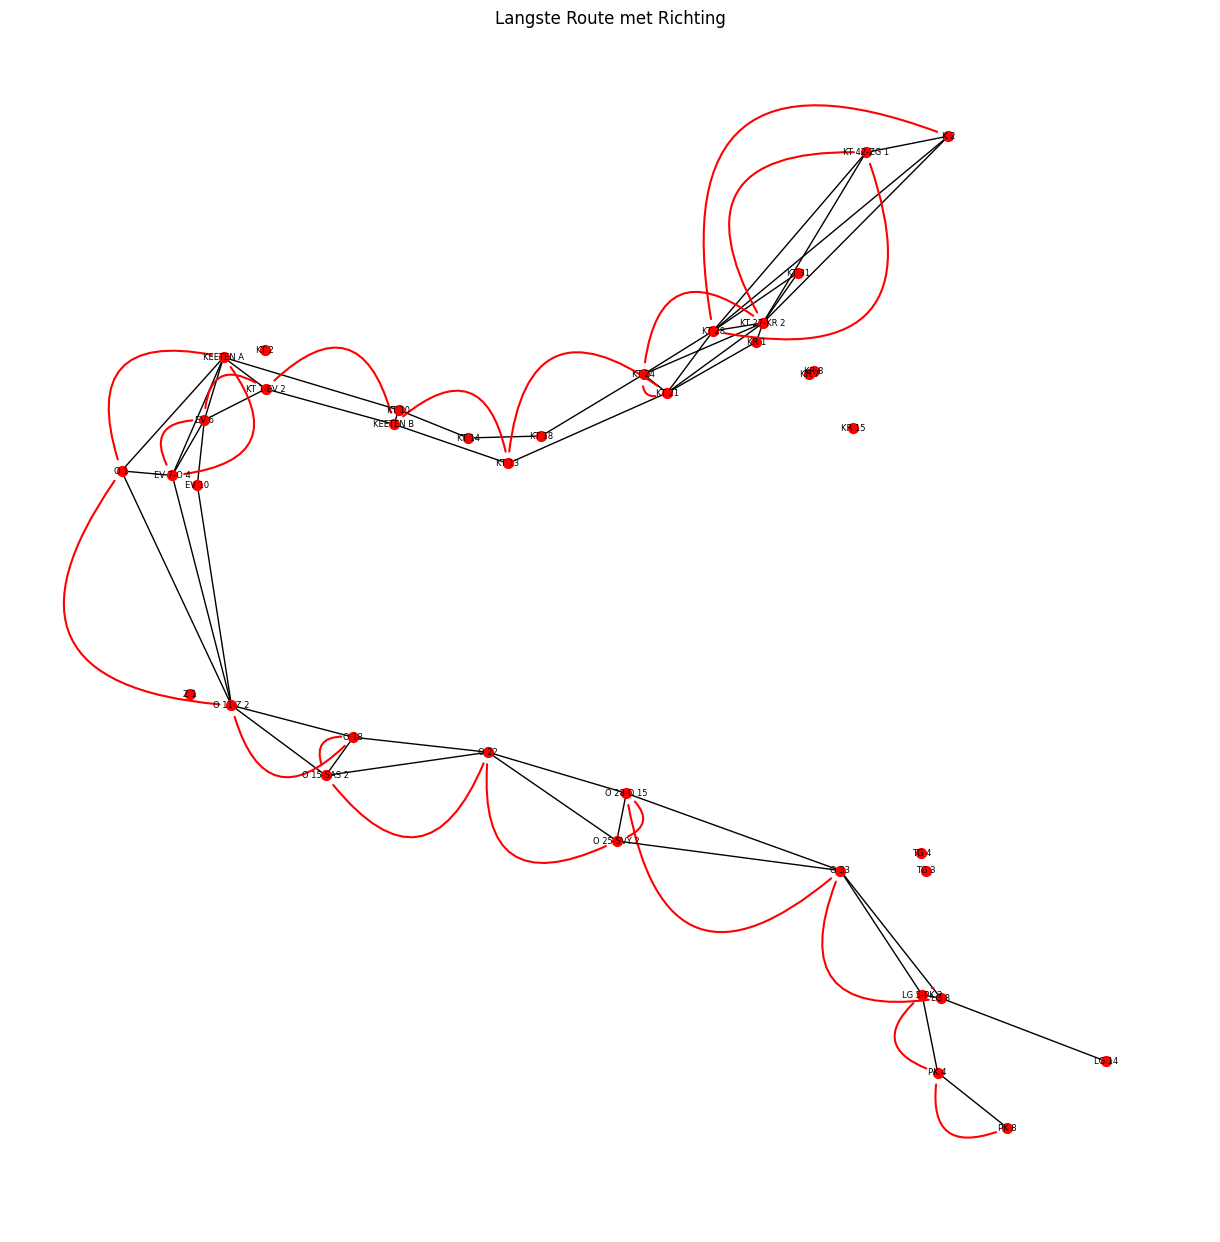

In [13]:
#ROUTE ZELF VISUALISEREN 

# Posities van de knooppunten ophalen
pos = nx.get_node_attributes(G, 'pos')

# Visualiseer de graaf
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=50, node_color="red", font_size=6)

# Highlight de langste route met pijlen voor richting
edges_in_path = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=edges_in_path,
    edge_color="red",
    width=1.5,
    arrows=True,  # Voeg pijlen toe om de richting aan te geven
    arrowsize=10,  # Grootte van de pijlen
    connectionstyle="arc3,rad=0.9"  # Maak de verbindingen licht gebogen voor betere leesbaarheid
)

# Titel en tonen
plt.title("Langste Route met Richting")
plt.show()


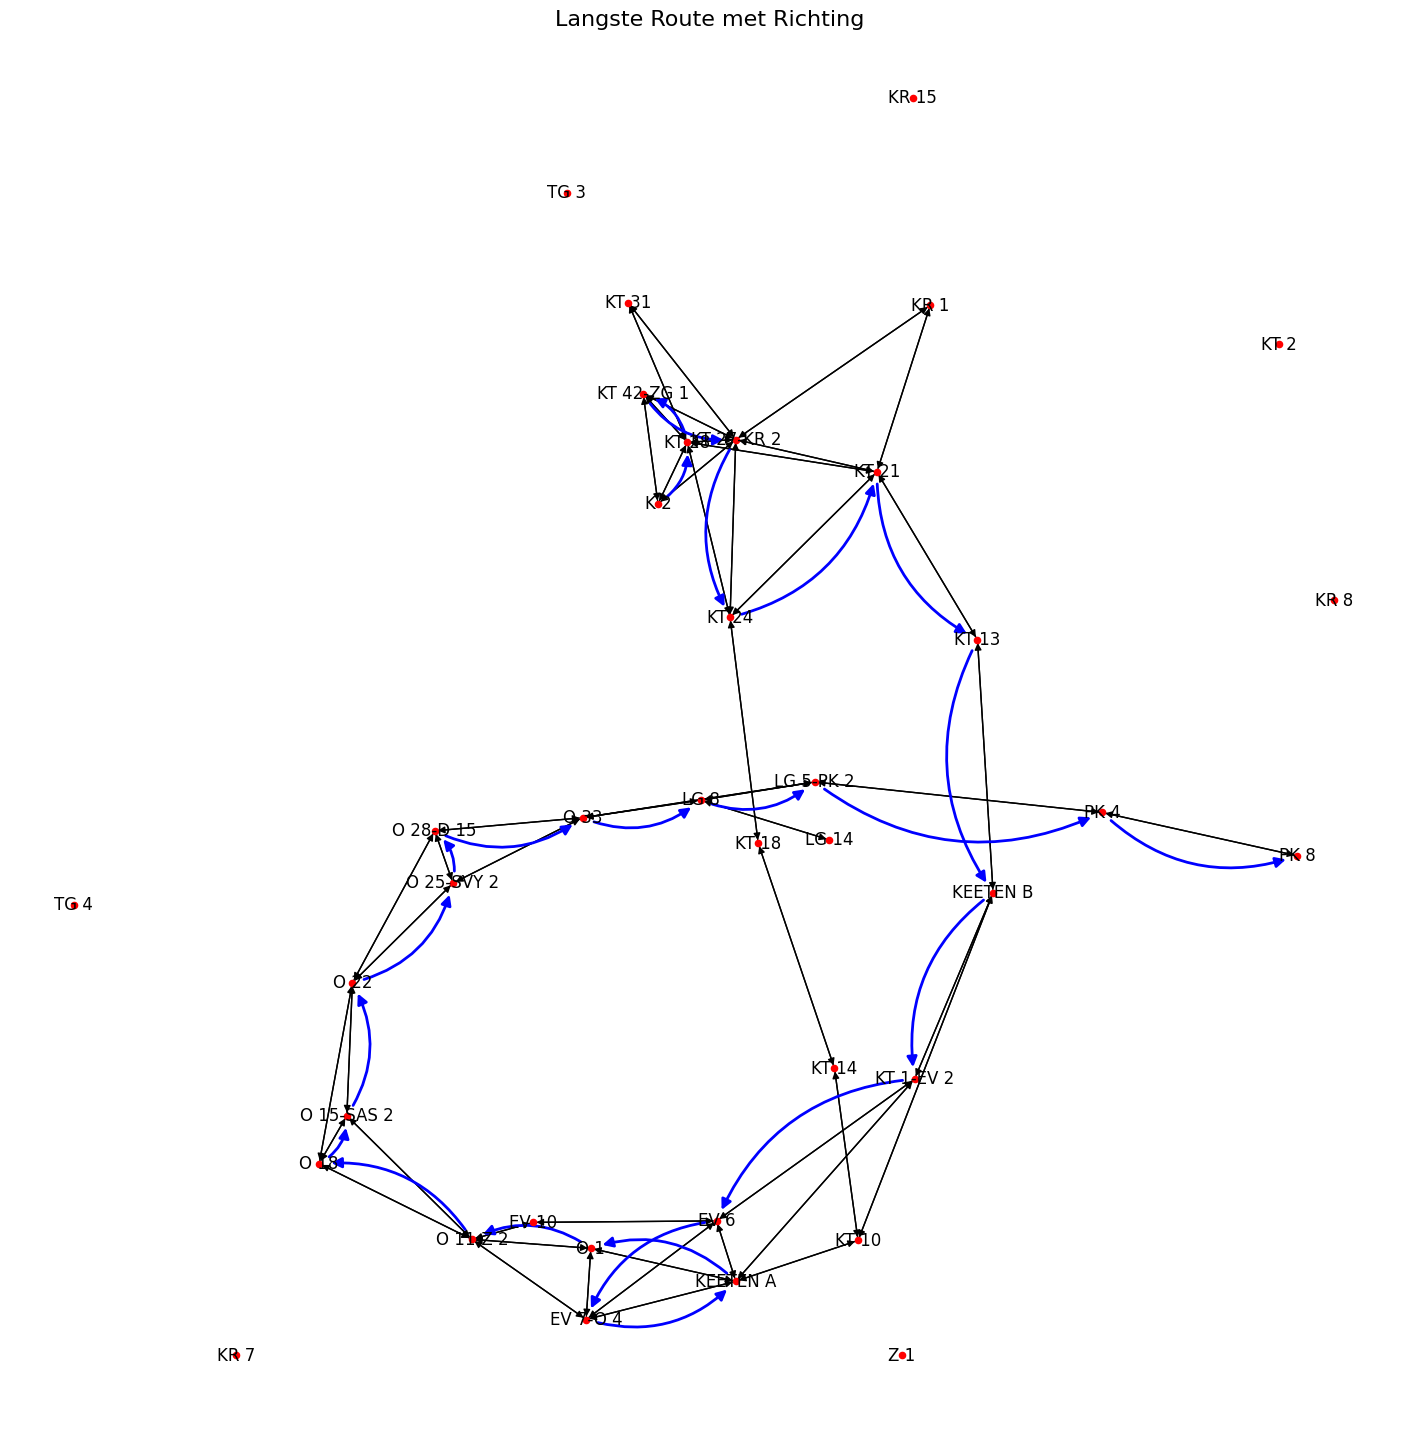

In [14]:
#route beter zichtbaar tussen knopen. niet geografisch accuraat

if not isinstance(G, nx.DiGraph):
    G = nx.DiGraph(G)

# Posities van de knooppunten ophalen met een spring-layout voor betere spreiding
pos = nx.spring_layout(G, k=5, seed=2137)  # De seed zorgt voor een consistente lay-out

# Visualiseer de volledige graaf
plt.figure(figsize=(14, 14))
nx.draw(G, pos, with_labels=True, node_size=20, node_color="red", font_size=12, font_color="black")

# Highlight de langste route met pijlen en een grotere kromming
edges_in_path = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=edges_in_path,
    edge_color="blue",  # Gebruik een andere kleur voor de route
    width=2,
    arrows=True,
    arrowsize=15,
    connectionstyle="arc3,rad=0.3"  # Grotere kromming voor betere leesbaarheid
)

# Titel en tonen
plt.title("Langste Route met Richting", fontsize=16)
plt.show()
